In [6]:
# !pip install wordcloud
# !pip install moviepy
# !pip install SpeechRecognition

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import re
from torch.nn.utils.rnn import pad_sequence
from torch.nn import Transformer
import torch.nn.functional as F
from transformers import AdamW
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\n\nDevice:", device, "\n\n")



Device: cuda 




In [5]:
import moviepy.editor as mp
import speech_recognition as sr
file_path = r"./common_voice_en_32392007.mp3"

audio_clip = mp.AudioFileClip(file_path)
audio_clip.write_audiofile("temp.wav")
recognizer = sr.Recognizer()
with sr.AudioFile("temp.wav") as source:
    audio_data = recognizer.record(source)
    text = recognizer.recognize_google(audio_data)
    print("Transcription:", text)


MoviePy - Writing audio in temp.wav


MoviePy - Done.
Transcription: San Antonio has an extremely wet tropical rainforest climate if he was nicknamed Captain Jack for his love of sailing


In [ ]:
import moviepy.editor as mp
import speech_recognition as sr
file_path = r"C:\Users\revat\Desktop\Spring 2024\CSE676-Deep Learning\Project\common_voice_en_32392007.mp3"

audio_clip = mp.AudioFileClip(file_path)
audio_clip.write_audiofile("temp.wav")
recognizer = sr.Recognizer()
with sr.AudioFile("temp.wav") as source:
    audio_data = recognizer.record(source)
    text = recognizer.recognize_google(audio_data)
    print("Transcription:", text)


In [4]:
eng_fr_df = pd.read_csv('/kaggle/input/language-translation-englishfrench/eng_-french.csv')

In [5]:
eng_fr_df

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !
...,...,...
175616,"Top-down economics never works, said Obama. ""T...","« L'économie en partant du haut vers le bas, ç..."
175617,A carbon footprint is the amount of carbon dio...,Une empreinte carbone est la somme de pollutio...
175618,Death is something that we're often discourage...,La mort est une chose qu'on nous décourage sou...
175619,Since there are usually multiple websites on a...,Puisqu'il y a de multiples sites web sur chaqu...


In [6]:
eng_fr_df.head()

,English words/sentences,French words/sentences
0,Hi.,Salut!
1,Run!,Cours !
2,Run!,Courez !
3,Who?,Qui ?
4,Wow!,Ça alors !


In [7]:
eng_fr_df.columns

Index(['English words/sentences', 'French words/sentences'], dtype='object')

In [8]:
eng_fr_df.dtypes

English words/sentences    object
French words/sentences     object
dtype: object

In [9]:
eng_fr_df.isnull().sum()

English words/sentences    0
French words/sentences     0
dtype: int64

In [10]:
eng_fr_df['English'] = eng_fr_df['English words/sentences'].str.lower()
eng_fr_df['French'] = eng_fr_df['French words/sentences'].str.lower()
eng_fr_df.drop(columns=['English words/sentences'], inplace=True)
eng_fr_df.drop(columns=['French words/sentences'], inplace=True)
eng_fr_df.head()

,English,French
0,hi.,salut!
1,run!,cours !
2,run!,courez !
3,who?,qui ?
4,wow!,ça alors !


In [11]:
def remove_special_chars(text):
    text = re.sub(r'http\S+', '', str(text))
    text = re.sub(r'[^a-zA-Z0-9\s]', '', str(text))
    text = text.lower()
    return text

In [12]:
eng_fr_df['English'] = eng_fr_df['English'].apply(remove_special_chars)
eng_fr_df['French'] = eng_fr_df['French'].apply(lambda x: re.sub(r'\d','',x))
eng_fr_df['French'] = eng_fr_df['French'].apply(lambda x: re.sub(r'\s+',' ',x))
eng_fr_df['French'] = eng_fr_df['French'].apply(lambda x: re.sub(r"[-()\"#/@;:<>{}`«+=~|.!?,।]", "", x))

In [13]:
eng_fr_df

,English,French
0,hi,salut
1,run,cours
2,run,courez
3,who,qui
4,wow,ça alors
...,...,...
175616,topdown economics never works said obama the c...,l'économie en partant du haut vers le bas ça ...
175617,a carbon footprint is the amount of carbon dio...,une empreinte carbone est la somme de pollutio...
175618,death is something that were often discouraged...,la mort est une chose qu'on nous décourage sou...
175619,since there are usually multiple websites on a...,puisqu'il y a de multiples sites web sur chaqu...


In [ ]:
plt.figure(figsize=(12,8))
wc = WordCloud(width=600,height=300).generate(' '.join(eng_fr_df['English']))
plt.imshow(wc)
plt.show()

In [ ]:
plt.figure(figsize=(12,8))
wc = WordCloud(width=600,height=300).generate(' '.join(eng_fr_df['French']))
plt.imshow(wc)
plt.show()

In [16]:
Eng_words = Counter([word for sentence in eng_fr_df['English'] for word in sentence.split()])
total_english_words = sum(len(sentence.split()) for sentence in eng_fr_df['English'])
distinct_english_words = len(Eng_words)
most_common_english_words = list(zip(*Eng_words.most_common(10)))[0]

print("Total number of English words:", total_english_words)
print("Number of unique English words:", distinct_english_words)
print("Top 10 most common English words:", most_common_english_words)

Total number of English words: 1082094
Number of unique English words: 14637
Top 10 most common English words: ('i', 'you', 'to', 'the', 'a', 'is', 'tom', 'that', 'he', 'do')


Text(0.5, 1.0, 'Top 10 Most Common English Words')

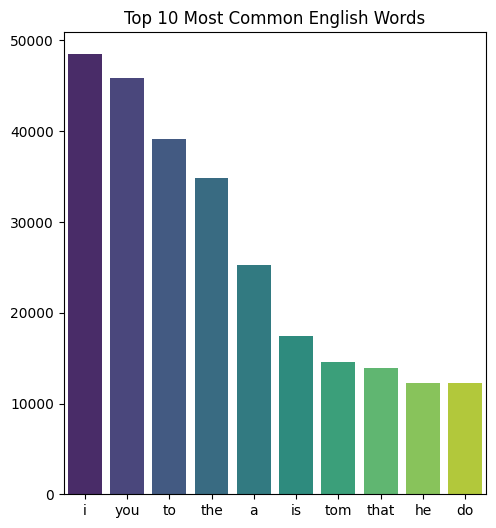

In [17]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
eng_word_freq = eng_fr_df['English'].str.split(expand=True).stack().value_counts().sort_values(ascending=False).head(10)
sns.barplot(y=eng_word_freq.values, x=eng_word_freq.index, palette='viridis')
plt.title('Top 10 Most Common English Words')


In [18]:
Fr_words = Counter([word for sentence in eng_fr_df['French'] for word in sentence.split()])
total_French_words = sum(len(sentence.split()) for sentence in eng_fr_df['French'])
distinct_French_words = len(Eng_words)
most_common_French_words = list(zip(*Fr_words.most_common(10)))[0]

print("Total number of French words:", total_english_words)
print("Number of unique French words:", distinct_French_words)
print("Top 10 most common French words:", most_common_French_words)

Total number of French words: 1082094
Number of unique French words: 14637
Top 10 most common French words: ('je', 'de', 'pas', 'que', 'à', 'ne', 'le', 'la', 'vous', 'il')


Text(0.5, 1.0, 'Top 10 Most Common French Words')

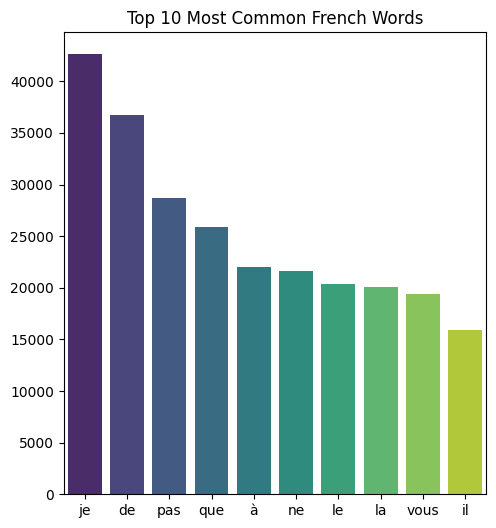

In [19]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
fr_word_freq = eng_fr_df['French'].str.split(expand=True).stack().value_counts().sort_values(ascending=False).head(10)
sns.barplot(y=fr_word_freq.values, x=fr_word_freq.index, palette='viridis')
plt.title('Top 10 Most Common French Words')


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Histogram of English Sentence Length')

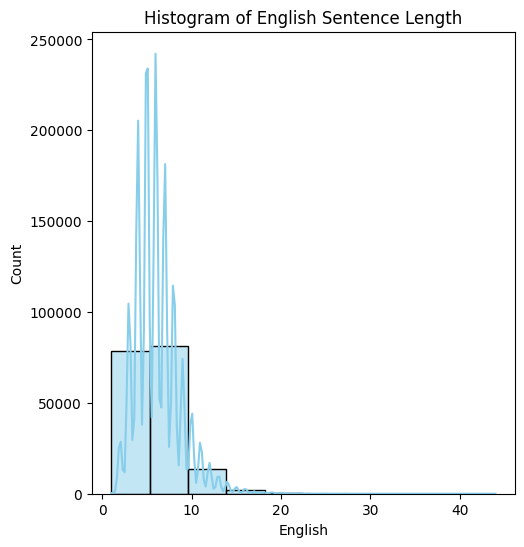

In [20]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(eng_fr_df['English'].str.split().apply(len), bins=10, kde=True, color='skyblue')
plt.title('Histogram of English Sentence Length')

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


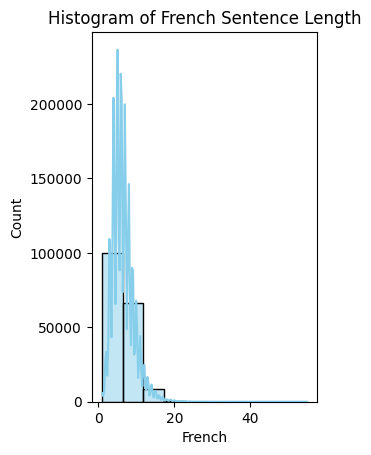

In [21]:
plt.subplot(1, 2, 2)
sns.histplot(eng_fr_df['French'].str.split().apply(len), bins=10, kde=True, color='skyblue')
plt.title('Histogram of French Sentence Length')
plt.show()

In [22]:
eng_vocab = {}
eng_idx = 1
english_tokens = []
max_len_eng_sentence = 0
for sentence in eng_fr_df['English']:
    tokens = sentence.split()
    len_tokens = len(tokens)
    max_len_eng_sentence = max(max_len_eng_sentence, len_tokens)
    for token in tokens:
        if token not in eng_vocab:
            eng_vocab[token] = eng_idx
            eng_idx += 1
    english_tokens.append(tokens)

In [23]:
fr_vocab = {}
fr_idx = 1
french_tokens = []
max_len_fr_sentence = 0
for sentence in eng_fr_df['French']:
    tokens = sentence.split()
    len_tokens = len(tokens)
    max_len_fr_sentence = max(max_len_fr_sentence, len_tokens)
    for token in tokens:
        if token not in fr_vocab:
            fr_vocab[token] = fr_idx
            fr_idx += 1
    french_tokens.append(tokens)

In [24]:
max_len_sentence = max(max_len_eng_sentence, max_len_fr_sentence)
max_len_sentence

55

In [25]:
eng_data = []
for tokens in english_tokens:
    eng_idx = [eng_vocab[token] for token in tokens]
    eng_idx = eng_idx + [0] * (max_len_sentence - len(eng_idx))
    eng_data.append(eng_idx)
print(eng_data[2])

[2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [26]:
fr_data = []
i = 0
for tokens in french_tokens:
    fr_idx = [fr_vocab[token] for token in tokens]
    fr_idx = fr_idx + [0] * (max_len_sentence - len(tokens))
    fr_data.append(fr_idx)

print(fr_data[2])

[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [27]:
X_train, X_test, y_train, y_test = train_test_split(eng_data, fr_data, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

X_train_tensors = torch.tensor([tokens for tokens in X_train])
y_train_tensors = torch.tensor([tokens for tokens in y_train])
X_val_tensors = torch.tensor([tokens for tokens in X_val])
y_val_tensors = torch.tensor([tokens for tokens in y_val])
X_test_tensors = torch.tensor([tokens for tokens in X_test])
y_test_tensors = torch.tensor([tokens for tokens in y_test])

train_dataset = TensorDataset(X_train_tensors, y_train_tensors)
val_dataset = TensorDataset(X_val_tensors, y_val_tensors)
test_dataset = TensorDataset(X_test_tensors, y_test_tensors)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


## Model 1 

In [45]:
class Eng_Fr_Translator(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, max_len, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout):
        super(Eng_Fr_Translator, self).__init__()
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers,
                                           num_decoder_layers=num_decoder_layers, dim_feedforward=dim_feedforward, dropout=dropout)
        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.max_len = max_len

    def forward(self, src, tgt):
        src = self.src_embedding(src)
        tgt = self.tgt_embedding(tgt)
        src = src.permute(1, 0, 2)
        tgt = tgt.permute(1, 0, 2)
        tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.size(0)).to(tgt.device)
        output = self.transformer(src, tgt, tgt_mask=tgt_mask)
        output = self.fc(output)
        return output.permute(1, 0, 2)

In [46]:
src_vocab_size = len(eng_vocab) + 1
tgt_vocab_size = len(fr_vocab) + 1
max_len = max_len_sentence
d_model = 128
nhead = 4
num_encoder_layers = 1
num_decoder_layers = 1
dim_feedforward = 2048
dropout = 0.5
lr = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model1 = Eng_Fr_Translator(src_vocab_size, tgt_vocab_size, max_len, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout).to(device)
optimizer = optim.AdamW(model1.parameters(), lr=lr, weight_decay = 0.001)
criterion = nn.CrossEntropyLoss(ignore_index=0)

In [47]:
num_epochs = 30

model1_train_losses = []
model1_val_losses = []

best_val_loss = float('inf')
patience = 5  
counter = 0  

for epoch in range(num_epochs):
    model1.train()
    model1_total_train_loss = 0
    for eng, fr in train_loader:
        eng, fr = eng.to(device), fr.to(device)
        optimizer.zero_grad()
        output = model1(eng, fr[:, :-1])
        output = output.reshape(-1, output.shape[-1])
        fr = fr[:, 1:].reshape(-1)
        loss = criterion(output, fr)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model1.parameters(), 1.0)
        optimizer.step()
        model1_total_train_loss += loss.item()
    model1_average_train_loss = model1_total_train_loss / len(train_loader)
    model1_train_losses.append(model1_average_train_loss)

    model1.eval()
    model1_total_val_loss = 0
    with torch.no_grad():
        for eng, fr in val_loader:
            eng, fr = eng.to(device), fr.to(device)
            output = model1(eng, fr[:, :-1])
            output = output.reshape(-1, output.shape[-1])
            fr = fr[:, 1:].reshape(-1)
            loss = criterion(output, fr)
            model1_total_val_loss += loss.item()
    model1_average_val_loss = model1_total_val_loss / len(val_loader)
    model1_val_losses.append(model1_average_val_loss)
    print(f'Epoch [{epoch+1}], Train Loss: {model1_average_train_loss:.4f}, Val Loss: {model1_average_val_loss:.4f}')
    
    if model1_average_val_loss < best_val_loss:
        best_val_loss = model1_average_val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Validation loss has not improved for {patience} epochs. Early stopping...')
            break


Epoch [1], Train Loss: 5.2687, Val Loss: 4.6376
Epoch [2], Train Loss: 4.1258, Val Loss: 4.1677
Epoch [3], Train Loss: 3.6112, Val Loss: 3.9324
Epoch [4], Train Loss: 3.2846, Val Loss: 3.7802
Epoch [5], Train Loss: 3.0572, Val Loss: 3.7150
Epoch [6], Train Loss: 2.8892, Val Loss: 3.6683
Epoch [7], Train Loss: 2.7587, Val Loss: 3.5836
Epoch [8], Train Loss: 2.6508, Val Loss: 3.5847
Epoch [9], Train Loss: 2.5675, Val Loss: 3.5584
Epoch [10], Train Loss: 2.4956, Val Loss: 3.5961
Epoch [11], Train Loss: 2.4365, Val Loss: 3.5374
Epoch [12], Train Loss: 2.3806, Val Loss: 3.5647
Epoch [13], Train Loss: 2.3364, Val Loss: 3.5807
Epoch [14], Train Loss: 2.2934, Val Loss: 3.5745
Epoch [15], Train Loss: 2.2579, Val Loss: 3.6127
Epoch [16], Train Loss: 2.2276, Val Loss: 3.5913
Validation loss has not improved for 5 epochs. Early stopping...


In [50]:
model1.eval()
model1_total_test_loss = 0
with torch.no_grad():
    for eng, fr in test_loader:
        eng, fr = eng.to(device), fr.to(device)
        output = model1(eng, fr[:, :-1])
        output = output.reshape(-1, output.shape[-1])
        fr = fr[:, 1:].reshape(-1)
        loss = criterion(output, fr)
        model1_total_test_loss += loss.item()
        
model1_average_test_loss = model1_total_test_loss / len(test_loader)
print(f'Test Loss: {model1_average_test_loss:.4f}')

Test Loss: 3.6057


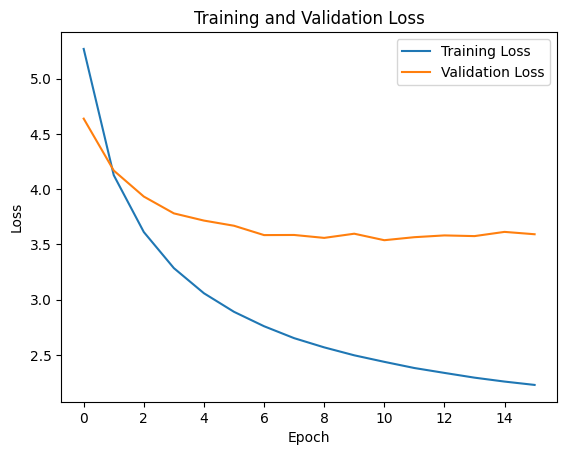

In [51]:
plt.plot(model1_train_losses, label='Training Loss')
plt.plot(model1_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model 2 With n_head = 4, dropout = 0.5

In [36]:
class Eng_Fr_Translator(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, max_len, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout):
        super(Eng_Fr_Translator, self).__init__()
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers,
                                           num_decoder_layers=num_decoder_layers, dim_feedforward=dim_feedforward, dropout=dropout)
        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.max_len = max_len

    def forward(self, src, tgt):
        src = self.src_embedding(src)
        tgt = self.tgt_embedding(tgt)
        src = src.permute(1, 0, 2)
        tgt = tgt.permute(1, 0, 2)
        tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.size(0)).to(tgt.device)
        output = self.transformer(src, tgt, tgt_mask=tgt_mask)
        output = self.fc(output)
        return output.permute(1, 0, 2)

In [38]:
src_vocab_size = len(eng_vocab) + 1
tgt_vocab_size = len(fr_vocab) + 1
max_len = max_len_sentence
d_model = 128
nhead = 4
num_encoder_layers = 1
num_decoder_layers = 1
dim_feedforward = 2048
dropout = 0.5
lr = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model2 = Eng_Fr_Translator(src_vocab_size, tgt_vocab_size, max_len, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout).to(device)
optimizer = optim.AdamW(model2.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=0)

In [39]:
num_epochs = 30

model2_train_losses = []
model2_val_losses = []

best_val_loss = float('inf')
patience = 5  
counter = 0  

for epoch in range(num_epochs):
    model2.train()
    model2_total_train_loss = 0
    for eng, fr in train_loader:
        eng, fr = eng.to(device), fr.to(device)
        optimizer.zero_grad()
        output = model2(eng, fr[:, :-1])
        output = output.reshape(-1, output.shape[-1])
        fr = fr[:, 1:].reshape(-1)
        loss = criterion(output, fr)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        optimizer.step()
        model2_total_train_loss += loss.item()
    model2_average_train_loss = model2_total_train_loss / len(train_loader)
    model2_train_losses.append(model2_average_train_loss)

    model2.eval()
    model2_total_val_loss = 0
    with torch.no_grad():
        for eng, fr in val_loader:
            eng, fr = eng.to(device), fr.to(device)
            output = model2(eng, fr[:, :-1])
            output = output.reshape(-1, output.shape[-1])
            fr = fr[:, 1:].reshape(-1)
            loss = criterion(output, fr)
            model2_total_val_loss += loss.item()
    model2_average_val_loss = model2_total_val_loss / len(val_loader)
    model2_val_losses.append(model2_average_val_loss)
    print(f'Epoch [{epoch+1}], Train Loss: {model2_average_train_loss:.4f}, Val Loss: {model2_average_val_loss:.4f}')
    
    if model2_average_val_loss < best_val_loss:
        best_val_loss = model2_average_val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Validation loss has not improved for {patience} epochs. Early stopping...')
            break


Epoch [1], Train Loss: 5.2343, Val Loss: 4.5412
Epoch [2], Train Loss: 4.0481, Val Loss: 4.0911
Epoch [3], Train Loss: 3.5176, Val Loss: 3.8257
Epoch [4], Train Loss: 3.1712, Val Loss: 3.6627
Epoch [5], Train Loss: 2.9349, Val Loss: 3.5756
Epoch [6], Train Loss: 2.7579, Val Loss: 3.5188
Epoch [7], Train Loss: 2.6220, Val Loss: 3.4252
Epoch [8], Train Loss: 2.5174, Val Loss: 3.3790
Epoch [9], Train Loss: 2.4314, Val Loss: 3.3824
Epoch [10], Train Loss: 2.3574, Val Loss: 3.3172
Epoch [11], Train Loss: 2.2946, Val Loss: 3.3297
Epoch [12], Train Loss: 2.2423, Val Loss: 3.3093
Epoch [13], Train Loss: 2.1982, Val Loss: 3.2847
Epoch [14], Train Loss: 2.1591, Val Loss: 3.2601
Epoch [15], Train Loss: 2.1214, Val Loss: 3.2899
Epoch [16], Train Loss: 2.0907, Val Loss: 3.2493
Epoch [17], Train Loss: 2.0614, Val Loss: 3.1889
Epoch [18], Train Loss: 2.0376, Val Loss: 3.2626
Epoch [19], Train Loss: 2.0160, Val Loss: 3.1755
Epoch [20], Train Loss: 1.9918, Val Loss: 3.1866
Epoch [21], Train Loss: 1.972

In [40]:
model2.eval()
model2_total_test_loss = 0
with torch.no_grad():
    for eng, fr in test_loader:
        eng, fr = eng.to(device), fr.to(device)
        output = model2(eng, fr[:, :-1])
        output = output.reshape(-1, output.shape[-1])
        fr = fr[:, 1:].reshape(-1)
        loss = criterion(output, fr)
        model2_total_test_loss += loss.item()
        
model2_average_test_loss = model2_total_test_loss / len(test_loader)
print(f'Test Loss: {model2_average_test_loss:.4f}')

Test Loss: 3.1391


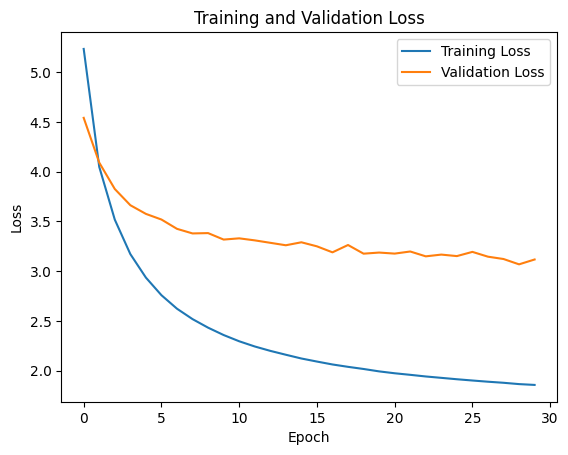

In [41]:
plt.plot(model2_train_losses, label='Training Loss')
plt.plot(model2_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model 3 with dropout = 0.1

In [28]:
class Eng_Fr_Translator(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, max_len, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout):
        super(Eng_Fr_Translator, self).__init__()
        self.src_embedding = nn.Embedding(src_vocab_size, d_model)
        self.tgt_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.transformer = nn.Transformer(d_model=d_model, nhead=nhead, num_encoder_layers=num_encoder_layers,
                                           num_decoder_layers=num_decoder_layers, dim_feedforward=dim_feedforward, dropout=dropout)
        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.max_len = max_len

    def forward(self, src, tgt):
        src = self.src_embedding(src)
        tgt = self.tgt_embedding(tgt)
        src = src.permute(1, 0, 2)
        tgt = tgt.permute(1, 0, 2)
        tgt_mask = self.transformer.generate_square_subsequent_mask(tgt.size(0)).to(tgt.device)
        output = self.transformer(src, tgt, tgt_mask=tgt_mask)
        output = self.fc(output)
        return output.permute(1, 0, 2)

In [30]:
src_vocab_size = len(eng_vocab) + 1
tgt_vocab_size = len(fr_vocab) + 1
max_len = max_len_sentence
d_model = 128
nhead = 8
num_encoder_layers = 1
num_decoder_layers = 1
dim_feedforward = 2048
dropout = 0.1
lr = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model3 = Eng_Fr_Translator(src_vocab_size, tgt_vocab_size, max_len, d_model, nhead, num_encoder_layers, num_decoder_layers, dim_feedforward, dropout).to(device)
optimizer = optim.AdamW(model3.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss(ignore_index=0)

In [31]:
num_epochs = 30

model3_train_losses = []
model3_val_losses = []

best_val_loss = float('inf')
patience = 5  
counter = 0  

for epoch in range(num_epochs):
    model3.train()
    model3_total_train_loss = 0
    for eng, fr in train_loader:
        eng, fr = eng.to(device), fr.to(device)
        optimizer.zero_grad()
        output = model3(eng, fr[:, :-1])
        output = output.reshape(-1, output.shape[-1])
        fr = fr[:, 1:].reshape(-1)
        loss = criterion(output, fr)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model3.parameters(), 1.0)
        optimizer.step()
        model3_total_train_loss += loss.item()
    model3_average_train_loss = model3_total_train_loss / len(train_loader)
    model3_train_losses.append(model3_average_train_loss)

    model3.eval()
    model3_total_val_loss = 0
    with torch.no_grad():
        for eng, fr in val_loader:
            eng, fr = eng.to(device), fr.to(device)
            output = model3(eng, fr[:, :-1])
            output = output.reshape(-1, output.shape[-1])
            fr = fr[:, 1:].reshape(-1)
            loss = criterion(output, fr)
            model3_total_val_loss += loss.item()
    model3_average_val_loss = model3_total_val_loss / len(val_loader)
    model3_val_losses.append(model3_average_val_loss)
    print(f'Epoch [{epoch+1}], Train Loss: {model3_average_train_loss:.4f}, Val Loss: {model3_average_val_loss:.4f}')
    
    if model3_average_val_loss < best_val_loss:
        best_val_loss = model3_average_val_loss
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Validation loss has not improved for {patience} epochs. Early stopping...')
            break

Epoch [1], Train Loss: 4.3875, Val Loss: 3.2910
Epoch [2], Train Loss: 2.9065, Val Loss: 2.7237
Epoch [3], Train Loss: 2.3615, Val Loss: 2.4956
Epoch [4], Train Loss: 2.0469, Val Loss: 2.3619
Epoch [5], Train Loss: 1.8360, Val Loss: 2.2790
Epoch [6], Train Loss: 1.6842, Val Loss: 2.2387
Epoch [7], Train Loss: 1.5654, Val Loss: 2.1946
Epoch [8], Train Loss: 1.4701, Val Loss: 2.1637
Epoch [9], Train Loss: 1.3934, Val Loss: 2.1384
Epoch [10], Train Loss: 1.3304, Val Loss: 2.1238
Epoch [11], Train Loss: 1.2735, Val Loss: 2.1126
Epoch [12], Train Loss: 1.2241, Val Loss: 2.1030
Epoch [13], Train Loss: 1.1808, Val Loss: 2.1008
Epoch [14], Train Loss: 1.1398, Val Loss: 2.0874
Epoch [15], Train Loss: 1.1056, Val Loss: 2.0772
Epoch [16], Train Loss: 1.0740, Val Loss: 2.0927
Epoch [17], Train Loss: 1.0453, Val Loss: 2.0807
Epoch [18], Train Loss: 1.0204, Val Loss: 2.0761
Epoch [19], Train Loss: 0.9950, Val Loss: 2.0746
Epoch [20], Train Loss: 0.9717, Val Loss: 2.0869
Epoch [21], Train Loss: 0.950

In [33]:
model3.eval()
model3_total_test_loss = 0
with torch.no_grad():
    for eng, fr in test_loader:
        eng, fr = eng.to(device), fr.to(device)
        output = model3(eng, fr[:, :-1])
        output = output.reshape(-1, output.shape[-1])
        fr = fr[:, 1:].reshape(-1)
        loss = criterion(output, fr)
        model3_total_test_loss += loss.item()
        
model3_average_test_loss = model3_total_test_loss / len(test_loader)
print(f'Test Loss: {model3_average_test_loss:.4f}')

Test Loss: 2.1115


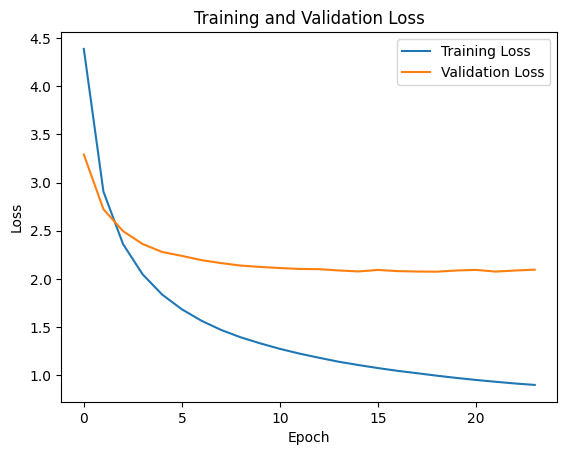

In [34]:
plt.plot(model3_train_losses, label='Training Loss')
plt.plot(model3_val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()
